<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/neo4jvector_langchain_deepdive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain openai wikipedia tiktoken neo4j

In [2]:
import os

from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.document_loaders import WikipediaLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document

os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

# Neo4j x LangChain: Deep dive into the new Vector index implementation
## Learn how to customize LangChain's wrapper of Neo4j vector index

Neo4j was and is an excellent fit for handling structured information, but it struggled a bit with semantic search due to its brute-force approach. However, the struggle is in the past as Neo4j has introduced a new vector index in version 5.11 designed to efficiently perform semantic search over unstructured text or other embedded data modalities. The newly added vector index makes Neo4j a great fit for most RAG applications as it now works great with both structured and unstructured data.

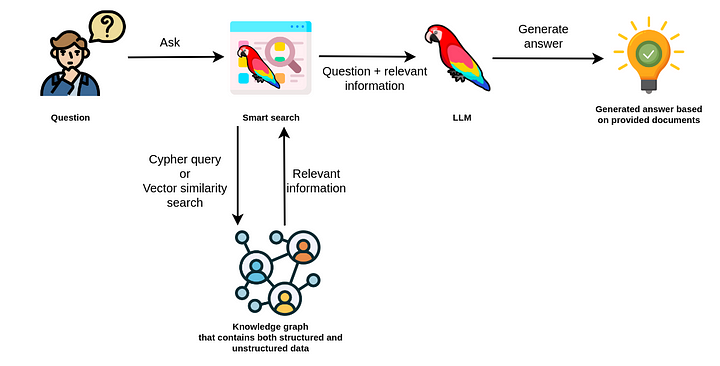

This blog post is designed to walk you through all the customization options available in the Neo4j Vector Index implementation in LangChain.

## Neo4j Environment setup
You need to setup a Neo4j 5.11 or greater to follow along with the examples in this blog post. The easiest way is to start a free instance on [Neo4j Aura](https://neo4j.com/cloud/platform/aura-graph-database/), which offers cloud instances of Neo4j database. Alternatively, you can also setup a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.
## Example dataset
For the purpose of this blog post, we will use the WikipediaLoader to fetch text from the Witcher page.

In [3]:
# Read the wikipedia article
raw_documents = WikipediaLoader(query="The Witcher").load()
# Define chunking strategy
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=20
)
# Chunk the document
documents = text_splitter.split_documents(raw_documents)
for d in documents:
    del d.metadata["summary"]

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


## Neo4j Vector index customization
Each text chunk is stored in Neo4j as a single isolated node.

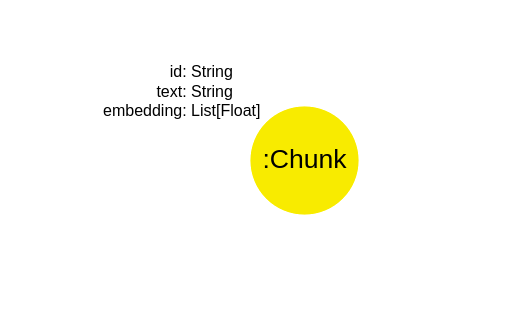

By default, Neo4j vector index implementation in LangChain represents the documents using the Chunk node label, where the text property stores the text of the document, and the embedding property holds the vector representation of the text. The implementation allows you to customize the node label, text and embedding property names.

In [4]:
url = "neo4j+s://databases.neo4j.io"
username = "neo4j"
password = "23VkKvkuXDGne9M"

neo4j_db = Neo4jVector.from_documents(
    documents,
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    database="neo4j",  # neo4j by default
    index_name="wikipedia",  # vector by default
    node_label="WikipediaArticle",  # Chunk by default
    text_node_property="info",  # text by default
    embedding_node_property="vector",  # embedding by default
    create_id_index=True,  # True by default
)

In this example, we have specified that we want to store text chunks under the WikipediaArticle node label, where the info property is used to store text, and the vector property holds the text embedding representation. If you run the above examples, you should see the following information in the database.

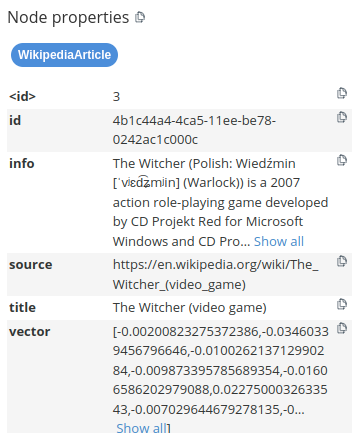

As mentioned, we define the info property to contain the text information, while the vector property is used to store the embedding. Any other properties like the source and title are treated as document metadata.

By default, we also create a unique node property constraint on the id property of the specified node label for faster imports. You can verify that the constraint has been created by using the following Cypher statement:

In [5]:
neo4j_db.query("SHOW CONSTRAINTS")

[{'id': 5,
  'name': 'constraint_e5da4d45',
  'type': 'UNIQUENESS',
  'entityType': 'NODE',
  'labelsOrTypes': ['WikipediaArticle'],
  'properties': ['id'],
  'ownedIndex': 'constraint_e5da4d45',
  'propertyType': None}]

As you would expect, we also create a vector index that will allow us to perform fast ANN searches.

In [6]:
neo4j_db.query(
    """SHOW INDEXES
       YIELD name, type, labelsOrTypes, properties, options
       WHERE type = 'VECTOR'
    """
)

[{'name': 'wikipedia',
  'type': 'VECTOR',
  'labelsOrTypes': ['WikipediaArticle'],
  'properties': ['vector'],
  'options': {'indexProvider': 'vector-1.0',
   'indexConfig': {'vector.dimensions': 1536,
    'vector.similarity_function': 'cosine'}}}]

The LangChain implementation created a vector index named wikipedia , which indexes the vector property of WikipediaArticle nodes. Additionally, the provided configuration informs us that the vector embedding dimension is 1536 and uses the cosine similarity function.
## Loading additional documents
You can use the add_documents method to load additional documents into an instantiated vector index.

In [7]:
neo4j_db.add_documents(
    [
        Document(
            page_content="LangChain is the coolest library since the Library of Alexandria",
            metadata={"author": "Tomaz", "confidence": 1.0}
        )
    ],
    ids=["langchain"],
)

['langchain']

LangChain allows you to provide document ids to the add_document method, which can be used to sync information across different system and make it easier to update or delete relevant text chunks.

## Loading existing index
If you have an existing vector index in Neo4j with populated data, you can use the from_existing_method to connect to it.

In [13]:
existing_index = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name="wikipedia",
    text_node_property="info",  # Need to define if it is not default
)

First, the from_existing_method checks if the index with the provided name actually exists in the database. If it exists, it can retrieve the node label and embedding node property from index configuration map, which means that you don't have to manually set those.

In [9]:
print(existing_index.node_label)
print(existing_index.embedding_node_property)

WikipediaArticle
vector


However, the index information does not contain the text node property information. Therefore, if you use any property besides the default one (text), specify it using the text_node_property parameter.
## Custom retrieval queries
Since Neo4j is a native graph database, the vector index implementation in LangChain allows customization and enrichment of the returned information. However, this feature is intended for more advanced users as you are responsible for custom data loading as well as retrieval.
The retrieval_query parameter allows you to collect, transform, or calculate any additional graph information you want to return from the similarity search. To better understand it, we can look at the actual implementation in the code.

```
read_query = (
    "CALL db.index.vector.queryNodes($index, $k, $embedding) "
    "YIELD node, score "
) + retrieval_query
```

From the code, we can observe that the vector similarity search is hardcoded. However, we then have the option to add any intermediate steps and return additional information. The retrieval query must return the following three columns:
* text (String): This is usually the textual data that is associated with the node that has been retrieved. This could be the main content of the node, a name, a description, or any other text-based information.
* score (Float): This represents the similarity score between the query vector and the vector associated with the returned node. The score quantifies how similar the query is to the returned nodes, often on a scale from 0 to 1
* metadata (Dictionary): This is a more flexible column that can contain additional information about the node or the search. It can be a dictionary (or map) that includes various attributes or properties that give more context to the returned node.

We will add a relationship to a WikipediaArticlenode to demonstrate this functionality.

In [10]:
existing_index.query(
    """MATCH (w:WikipediaArticle {id:'langchain'})
       MERGE (w)<-[:EDITED_BY]-(:Person {name:"Galileo"})
    """
)

[]

We have added an EDITED_BY relationship to the WikipediaArticle node with the given id. Let's now test out a custom retrieval option.

In [11]:
retrieval_query = """
OPTIONAL MATCH (node)<-[:EDITED_BY]-(p)
WITH node, score, collect(p) AS editors
RETURN node.info AS text,
       score,
       node {.*, vector: Null, info: Null, editors: editors} AS metadata
"""

existing_index_return = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    database="neo4j",
    index_name="wikipedia",
    text_node_property="info",
    retrieval_query=retrieval_query,
)

I won't go too much into the specifics of Cypher. You can use many resources to learn the basic syntax and more like the Neo4j Graph Academy. To construct a valid retrieval query, you must know that the relevant node from the vector similarity search is available under the node reference variable, while the similarity metric value is available under the score reference.

Let's try it out.

In [12]:
existing_index_return.similarity_search("What do you know about LangChain?", k=1)

[Document(page_content='LangChain is the coolest library since the Library of Alexandria', metadata={'author': 'Tomaz', 'confidence': 1.0, 'id': 'langchain', 'editors': [{'name': 'Galileo'}]})]